**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
лемматизация + TFIDF + DBSCAN

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

from matplotlib import pyplot as plt

from pymorphy2 import MorphAnalyzer

SKLEARN_VERSION

'0.24.1'

## тексты

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [4]:
data.sample(2)

,text,tag
1598,"Глава МИД России Сергей Лавров прокомментировал высказывание президента Хорватии Колинды Грабар-Китарович о стремлении Москвы спровоцировать конфликт на Балканах. Об этом во вторник, 13 декабря, с...",politics
2289,"Минувшим вечером на окраинах Екатеринбурга горел банный комплекс, расположенный на улице Водонасосной. Сообщение о пожаре поступило в 19:52. На место ЧП выехали 11 пожарных машин и 37 человек личн...",incident


## токенизация и очистка

In [5]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [6]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()

# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# NOUN (существительное), VERB (глагол), ADJF (прилагательное)
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''


def tokenize_normalize(s):
    return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [7]:
data['ctext'] = data['text']\
                    .progress_apply(string_normalizer)\
                    .progress_apply(tokenize_normalize)

100%|██████████| 3196/3196 [01:20<00:00, 39.80it/s]


In [8]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 22673 слов


In [9]:
data['ctext'] = data['ctext'].apply(' '.join)

In [10]:
data.sample(10)

,text,tag,ctext
3193,"Окно возможностей В Эвенкинском муниципальном районе приступили к\nисследованию традиционного уклада жизни. В Эвенкию прибыла экспедиция под\nруководством профессора, заведующего кафедрой менеджме...",science,окно возможность муниципальный район приступить исследование традиционный уклад жизнь эвенкия прибыть экспедиция руководство профессор кафедра менеджмент высокий технология сибирский федеральны...
2658,"Ученые из Университета Эдинбурга выяснили, что инопланетная жизнь может существовать в верхних слоях атмосферы коричневых планет-карликов, на которых температура и давление близки к земным показат...",science,учёный университет эдинбург выяснить инопланетный жизнь мочь верхний слой атмосфера коричневый который температура давление земной показатель писать внеземной жизнь мочь коричневый карл...
2411,"12 декабря 2016, 11:51\n\nНатали Портман в роли Падме Амидалы © Стоп-кадр из фильма «Звездные войны»\n\nГолливудские актеры Натали Портман и Кейси Аффлек получили главные награды премии Critics' C...",culture,декабрь натали роль стоп-кадр фильм звёздный война голливудский актёр натали получить главный награда премия звание хороший актриса год роль фильм джеки жена президент сша джон кеннед...
1846,"Министр иностранных дел России Сергей Лавров заявил, что высказывания об угрозе конфликта с РФ на Балканах странно слышать от Хорватии, но Москва готова обсудить факты Загреба при их наличии.\n\nР...",politics,министр иностранный дело россия сергей лавров заявить высказывание угроза конфликт рф балканы хорватия москва факт загреб наличие сми появиться информация тот президент хорватия гов...
186,"Intel и STMicro стандартизируют мобильную флэш-память По условиям\nсоглашения между Intel и STMicro, выпускаемые обеими компаниями чипы\nфлэш-памяти NOR для сотовых телефонов будут идентичными. Эт...",tech,стандартизировать мобильный условие соглашение компания чип сотовый телефон быть идентичный касаться микросхема который производить выпуск последний быть год ожидаться сотр...
878,"""J:морс"" сняли клип на мобильный телефон. Премьера TUT\n\n1 декабря 2016 в 11:06\n\nAFISHA.TUT.BY\n\nГруппа «J:морс» представила видео на песню «Не мой дождь» — одну из самых романтических компози...",culture,морс снять клип мобильный телефон премьера декабрь группа морс представить видео песня мой дождь один самый романтический композиция альбом воздух песня писать день месяц рассказыва...
2362,"РИАМО - 13 дек. Дознаватель столичной полиции выпала из окна квартиры, расположенной на седьмом этаже жилого дома на улице Сумская в Москве, пострадавшая госпитализирована, сообщил РИАМО во вторни...",incident,дек дознаватель столичный полиция выпасть окно квартира седьмой этаж жилой дом улица сумский москва сообщить вторник представитель пресс-служба мвд россия москва уточнить декабрь час ...
169,"Папа римский дал аудиенцию ""Феррари"" Президент ""Феррари"" Лука ди Монтеземоло\nи делегация представителей компании встретилась в понедельник с папой\nримским Бенедиктом XVI.... Феррари"" уже второй ...",sport,папа римский дать аудиенция феррари президент феррари лука делегация представитель компания встретиться понедельник папа римский бенедикт феррари второй раз получить аудиенция папа январь боль...
3172,Кадровые назначения Палата утвердила решения об избрании Николая Львова -\nпервым заместителем председателя Комитета Совета Федерации по делам Севера и\nмалочисленных народов. Палата утвердила ре...,politics,кадровый назначение палата утвердить решение избрание николай львов первый заместитель председатель комитет совет федерация дело север малочисленный народ палата утвердить решение избрание анат...
2908,"Подписывайтесь на наш Telegram , чтобы быть в курсе самых важных новостей.Для этого нужно пройти по ссылке и нажать кнопку Join.\n\nНемецкая компания Volkswagen намерена выпустить новый большой пи...",auto,подписываться наш курс самый важный новость ссылка кнопка немецкий компания новый большой пикап который быть размер модель представитель бр

##  Vectorizer

In [11]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

X = TfidfVectorizer(use_idf=True,norm='l2',tokenizer=tokenizer,token_pattern=None).fit_transform( data['ctext'] )

## кластеризируем

In [12]:
data['cluster'] = DBSCAN(eps=.85,min_samples=5).fit(X).labels_
data['cluster'].drop_duplicates().count()

60

## тестируем

In [13]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,-1,2672,science culture economics social incident sport health woman reclama auto realty politics tech
1,0,6,economics
2,1,21,politics
3,2,9,politics
4,3,13,politics
5,4,11,politics
6,5,9,politics
7,6,7,politics
8,7,30,politics
9,8,5,politics


<AxesSubplot:xlabel='cluster'>

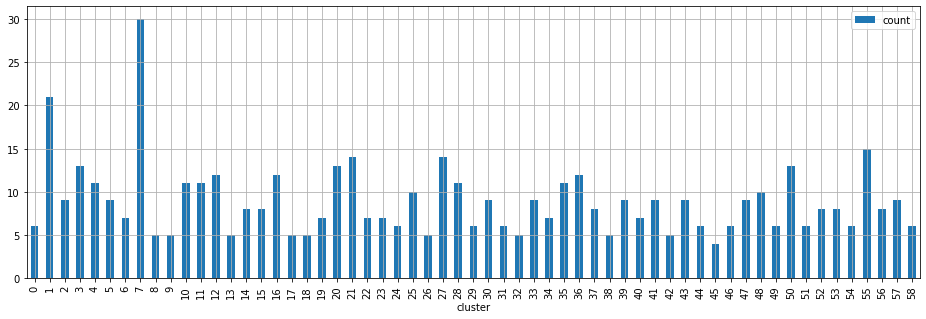

In [14]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [15]:
# def print_cluster_samples(n,ns=5,nt=100):
#     count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
#     top = [ t[:nt].replace('\n',' ') for t in data.query(f'cluster=={n}')['text'].sample(ns).values ]
#     print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
#     for s in top: print('\n%s ...\n'%(s) )

In [16]:
def print_cluster_samples(n,ns=3,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [17]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 6, элементов: 7, метки: "politics" ]

Венесуэла закрыла границу с Колумбией на 72 часа для борьбы с мафией, которая занималась экономическими преступлениями. Об этом сообщает РИА "Новости".  Отмечается, что президент Венесуэлы Николас Мадуро распорядился закрыть границу, так как озабочен происходящим на границе.  По некоторым данным, за ...


Венесуэла закрывает границу с Колумбией из-за валютной мафии Код для вставки в блог Телеканал "Звезда"Венесуэла закрывает границу с Колумбией из-за валютной мафии13 декабря 2016, 03:21Президент Венесуэлы Николас Мадуро распорядился закрыть границу с Колумбией на 72 часа для пресечения деятельности ф ...


Венесуэла закрыла границу с Колумбией  Москва. 13 декабря. INTERFAX.RU - Президент Венесуэлы Николас Мадуро отдал приказ закрыть границу с Колумбией на 72 часа и использовать их для борьбы с контрабандой валюты, сообщило во вторник агентство Associated Press.  По словам Мадуро, мафия, действующая на ...


= = = = = = = = = = = = = = = =